In [ ]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from drain3.template_miner import TemplateMiner
from drain3.file_persistence import FilePersistence
from drain3.template_miner_config import TemplateMinerConfig
from scipy.sparse._csr import csr_matrix
from gensim.models import Word2Vec

from utils import (
    preprocess_text_stem,
    parse_failed_verdicts,
    get_weighted_word_embedding_vector,
    plot_silhouette_scores,
)

nltk.download("stopwords")

### Preprocessing for test case meta data

In [ ]:
do_preprocessing = False

test_case_meta_path = os.path.join("")
df_save_name = "passed_and_failed_cases_preprocessed.parquet"

if do_preprocessing:
    df = pd.read_parquet(
        os.path.join(test_case_meta_path, "passed_and_failed_cases.parquet")
    )

    ps = PorterStemmer()

    detailed_reason_preprocessed = pd.Series(
        df["verification.detailed_reason"].apply(
            lambda x: preprocess_text_stem(parse_failed_verdicts(x))
        ),
        name="detailed_reason_preprocessed",
    )
    error_message_preprocessed = pd.Series(
        df["state.errorMessage"].apply(lambda x: preprocess_text_stem(x)),
        name="error_message_preprocessed",
    )

    df = pd.concat(
        [df, detailed_reason_preprocessed, error_message_preprocessed], axis=1
    )

    df.to_parquet(os.path.join(test_case_meta_path, df_save_name))
else:
    df = pd.read_parquet(os.path.join(test_case_meta_path, df_save_name))


# Combine preprocessed verification.detailed_reason and state.errorMessage columns into one column
def combine_columns(column1: pd.Series, column2: pd.Series) -> pd.Series:
    combined = []
    for string1, string2 in zip(column1, column2):
        if string1:
            if not string2:
                combined.append(string1)
                continue
            combined.append(string1 + " " + string2)
            continue
        if string2:
            combined.append(string2)
            continue
        combined.append(None)
    return pd.Series(combined)


df["reason_and_message"] = combine_columns(
    df["detailed_reason_preprocessed"], df["error_message_preprocessed"]
)
df.drop_duplicates(subset="_id", inplace=True)
df.dropna(subset="reason_and_message", inplace=True)

### Calculate TF-IDF features

In [5]:
min_df = 5

In [4]:
vectorizer = TfidfVectorizer(min_df=min_df)
feature_vector_tfidf = vectorizer.fit_transform(df["reason_and_message"])

### Calculate Word2Vec weighted by TF-IDF features

In [7]:
calculate_features = False
if calculate_features:
    vectorizer = TfidfVectorizer(min_df=min_df)
    vectorizer.fit(df["reason_and_message"])
    tokens = df["reason_and_message"].apply(lambda x: word_tokenize(x))
    model = Word2Vec(tokens)
    feature_vector_word2vec = df["reason_and_message"].apply(
        lambda x: get_weighted_word_embedding_vector(x, model, vectorizer)
    )
    df["word2vec_tfidf_features"] = feature_vector_word2vec
    df.to_parquet(
        os.path.join(
            test_case_meta_path,
            "preprocessed_test_case_meta_with_word2vec_tfidf_features.parquet",
        )
    )
else:
    feature_vector_word2vec = pd.read_parquet(
        os.path.join(
            test_case_meta_path,
            "preprocessed_test_case_meta_with_word2vec_tfidf_features.parquet",
        )
    )["word2vec_tfidf_features"]
feature_vector_word2vec = np.stack(feature_vector_word2vec.values)

### Plot silhouette scores

100%|██████████| 49/49 [01:44<00:00,  2.13s/it]


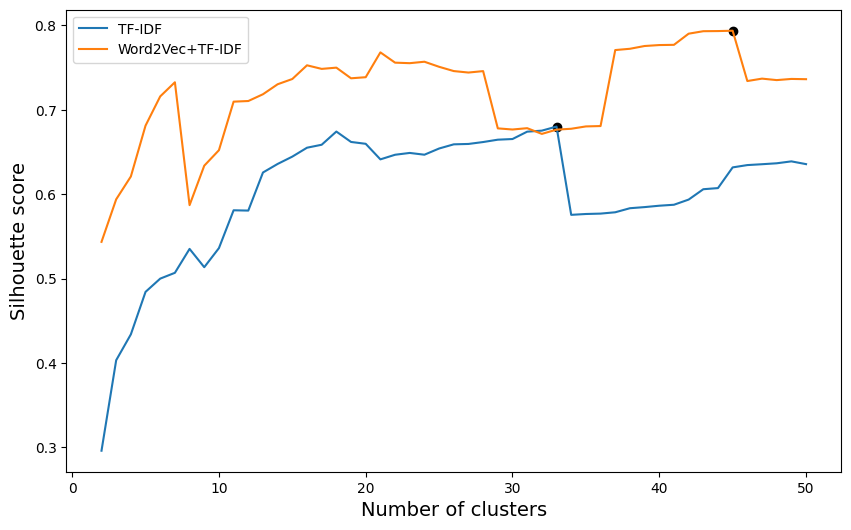

Number of clusters with max silhouette scores: [33, 45]


In [8]:
features = [feature_vector_tfidf, feature_vector_word2vec]

plot_silhouette_scores(
    features,
    min_k=1,
    max_k=50,
    legend_labels=[
        "TF-IDF",
        "Word2Vec+TF-IDF",
    ]
)

### Clustering with TF-IDF

Cluster sizes:
 [1553, 430, 650, 193, 234, 261, 39, 257, 13, 326, 139, 284, 80, 335, 140, 659, 23, 99, 157, 60, 229, 47, 29, 95, 87, 158, 60, 38, 29, 13, 62, 13, 47]
Silhouette score: 0.6801035503155809


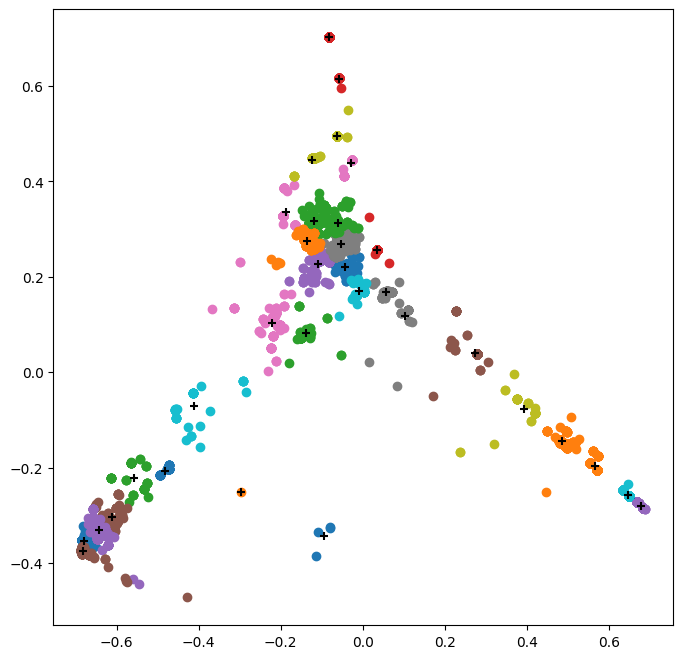

In [9]:
k = 33
feature_vector = feature_vector_tfidf

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()

### Clustering with Word2Vec weighted by TF-IDF

Cluster sizes:
 [1667, 319, 650, 26, 253, 254, 73, 30, 54, 220, 3, 350, 22, 179, 43, 47, 17, 10, 169, 79, 29, 78, 56, 105, 82, 113, 19, 12, 652, 45, 57, 226, 17, 9, 66, 21, 385, 20, 95, 15, 1, 121, 20, 127, 3]
Silhouette score: 0.7936392


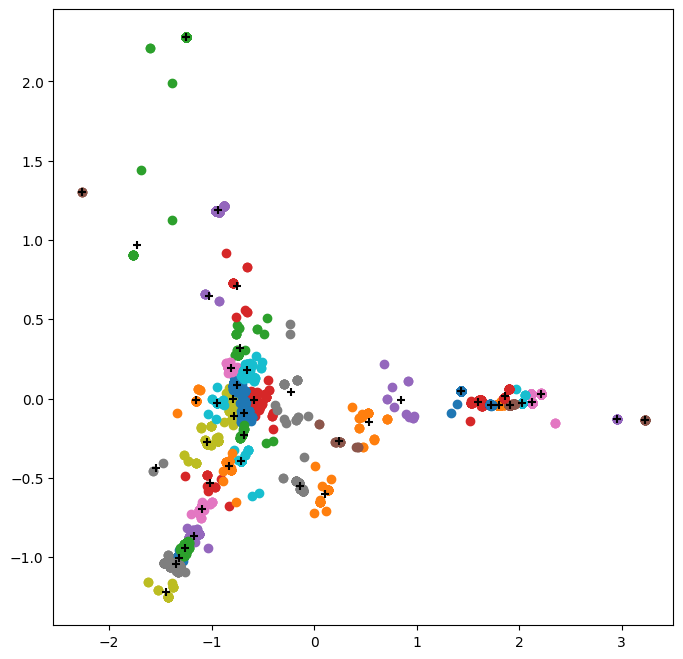

In [10]:
k = 45
feature_vector = feature_vector_word2vec

kmeans = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters = kmeans.fit_predict(feature_vector)

size_of_clusters = [np.count_nonzero(clusters == i) for i in range(k)]
print("Cluster sizes:\n", size_of_clusters)

score = silhouette_score(feature_vector, clusters, metric="euclidean")
print("Silhouette score:", score)

# Visualization using PCA
pca = PCA(2)
if isinstance(feature_vector, csr_matrix):
    transformed_features = pca.fit_transform(np.asarray(feature_vector.todense()))
else:
    transformed_features = pca.fit_transform(np.asarray(feature_vector))

kmeans_2_dim = KMeans(n_clusters=k, n_init="auto", random_state=1)
clusters_2_dim = kmeans_2_dim.fit_predict(transformed_features)

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(
        transformed_features[clusters_2_dim == i, 0],
        transformed_features[clusters_2_dim == i, 1],
        label=i,
    )
plt.scatter(
    kmeans_2_dim.cluster_centers_[:, 0],
    kmeans_2_dim.cluster_centers_[:, 1],
    color="black",
    marker="+",
    label="centroid",
)
plt.show()